In [4]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# Define the function first
def process_data(folder_path):
    all_data = []  # Initialize all_data inside the function to avoid overwriting
    # Loop over all files in the directory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
    
        # Check if the current item is a file (not a directory)
        if os.path.isfile(file_path):
            # print(f"Processing file: {filename}")  # Debugging print statement
            
            try:
                with open(file_path, 'r') as f:
                    content = f.read()
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
                continue
    
            # Regular expressions for matching the relevant fields
            user_time = r"User time \(seconds\):\s*([0-9.]+)"
            cpu_percent = r"Percent of CPU this job got:\s*([0-9]+)"
            major_faults = r"Major \(requiring I/O\) page faults:\s*(\d+)"
            minor_faults = r"Minor \(reclaiming a frame\) page faults:\s*(\d+)"
            qubits = r'Command being timed: "python3 deutsch-jozsa.py (\d+)"'
    
            # Find the number of qubits in the file (assuming there's only one qubit number per file)
            qubit_match = re.search(qubits, content)
            qubit_number = qubit_match.group(1) if qubit_match else None
            # print(f"Qubits in {filename}: {qubit_number}")  # Debugging print statement
            
            # Find all matches for each pattern
            user_times = re.findall(user_time, content)
            cpu_percents = re.findall(cpu_percent, content)
            major_faults = re.findall(major_faults, content)
            minor_faults = re.findall(minor_faults, content)
    
            # Check if lengths of matches are consistent
            if len(user_times) == len(cpu_percents) == len(major_faults) == len(minor_faults):
                # Combine the results into a structured list
                for i in range(len(user_times)):
                    all_data.append({
                        'Filename': filename,
                        'Qubits': qubit_number,
                        'User Time (s)': user_times[i],
                        'CPU Percent': cpu_percents[i],
                        'Major Page Faults': major_faults[i],
                        'Minor Page Faults': minor_faults[i]
                    })
            else:
                print(f"Mismatch in data lengths for file {filename}. Skipping this file.")
                continue
            
        else:
            print(f"Skipping non-file: {filename}")  # Debugging print statement
    
    # Convert the aggregated data into a DataFrame for easier analysis
    df = pd.DataFrame(all_data)
    
    # Display the DataFrame
    print(df)
    return df

# Define the paths to your two folders
dj_a100_path = '/scratch/network/er4138/iw/dj_a100'
df_dj_a100 = process_data(dj_a100_path)
df_dj_a100.to_csv('/scratch/network/er4138/iw/df_dj_a100.csv', index=False)

dj_v100_path = '/scratch/network/er4138/iw/dj_v100'
df_dj_v100 = process_data(dj_v100_path)
df_dj_v100.to_csv('/scratch/network/er4138/iw/df_dj_v100.csv', index=False)

Skipping non-file: .ipynb_checkpoints
              Filename Qubits User Time (s) CPU Percent Major Page Faults  \
0    slurm-2358335.out      6          0.74          64                 0   
1    slurm-2358335.out      6          0.74          82                 0   
2    slurm-2358335.out      6          0.73          82                 0   
3    slurm-2358335.out      6          0.73          81                 0   
4    slurm-2358335.out      6          0.72          82                 0   
..                 ...    ...           ...         ...               ...   
295  slurm-2358360.out     31          1.19          85                 0   
296  slurm-2358360.out     31          1.19          86                 0   
297  slurm-2358360.out     31          1.19          80                 0   
298  slurm-2358360.out     31          1.20          86                 0   
299  slurm-2358360.out     31          1.18          86                 0   

    Minor Page Faults  
0            

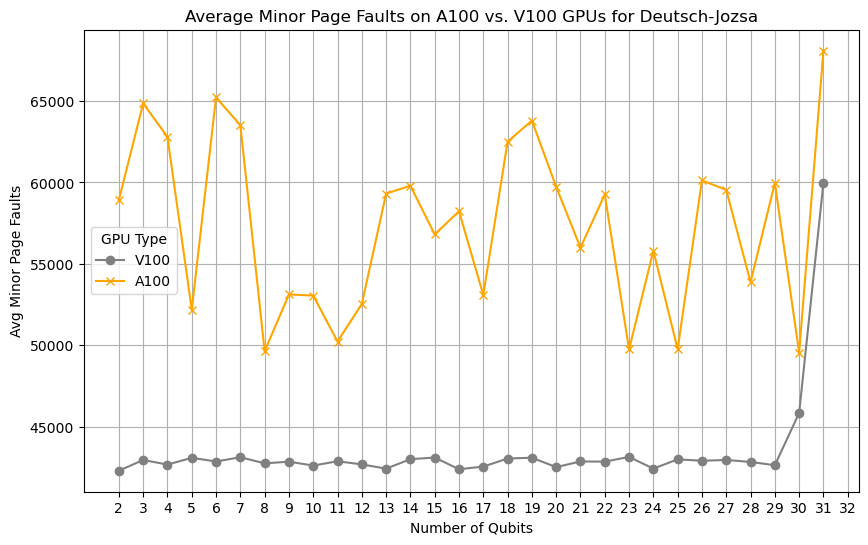

In [37]:
# Function to compute average minor page faults for the last 5 runs per qubit number
def compute_avg_minor_faults(df):
    
    avg_faults_list = []
    
    # Loop over qubit values from 2 to 31 and compute the average of the last 5 runs
    for qubit in range(2, 32):
        df['Qubits'] = pd.to_numeric(df['Qubits'], errors='coerce')
        df['Minor Page Faults'] = pd.to_numeric(df['Minor Page Faults'], errors='coerce')
        df_filtered = df[df['Qubits'] == qubit]
        avg_faults_list.append(df_filtered['Minor Page Faults'].iloc[-5:].mean())
    
    return avg_faults_list

# Compute the averages for both GPUs
avg_minor_v100 = compute_avg_minor_faults(df_dj_v100)
avg_minor_a100 = compute_avg_minor_faults(df_dj_a100)

# Define qubit range
qubits = np.arange(2, 32)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(qubits, avg_minor_v100, label="V100", marker='o', color='grey')
plt.plot(qubits, avg_minor_a100, label="A100", marker='x', color='orange')

# Labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Avg Minor Page Faults')
plt.title('Average Minor Page Faults on A100 vs. V100 GPUs for Deutsch-Jozsa')
plt.legend(title="GPU Type")

plt.xticks(np.arange(2, 33, 1))  # Ensure that ticks are from 2 to 32

# Show the plot
plt.grid(True)
plt.show()


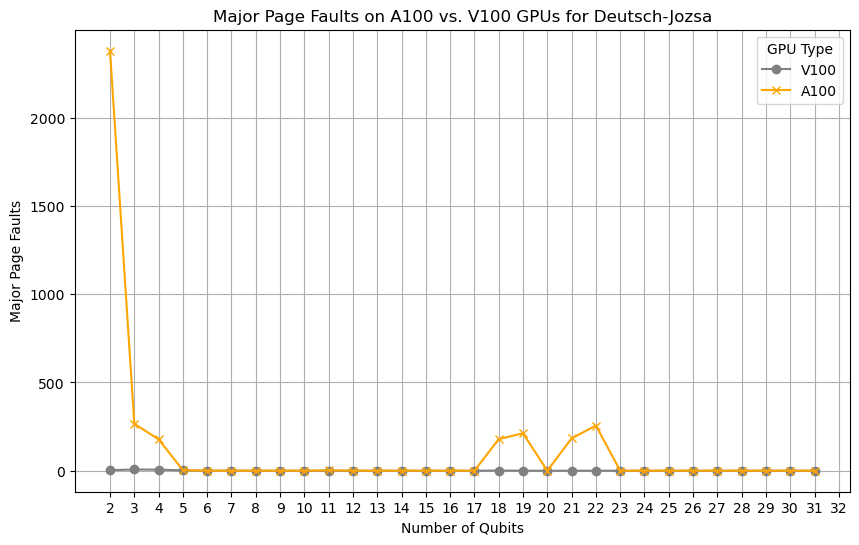

In [38]:
# Function to compute average minor page faults for the last 5 runs per qubit number
def compute_maj_faults(df):
    
    maj_faults_list = []
    
    # Loop over qubit values from 2 to 31 and compute the average of the last 5 runs
    for qubit in range(2, 32):
        df['Qubits'] = pd.to_numeric(df['Qubits'], errors='coerce')
        df['Major Page Faults'] = pd.to_numeric(df['Major Page Faults'], errors='coerce')
        df_filtered = df[df['Qubits'] == qubit]
        maj_faults_list.append(df_filtered['Major Page Faults'].iloc[0])
    
    return maj_faults_list

# Compute the averages for both GPUs
maj_faults_v100 = compute_maj_faults(df_dj_v100)
maj_faults_a100 = compute_maj_faults(df_dj_a100)

# Define qubit range
qubits = np.arange(2, 32)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(qubits, maj_faults_v100, label="V100", marker='o', color='grey')
plt.plot(qubits, maj_faults_a100, label="A100", marker='x', color='orange')

# Labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Major Page Faults')
plt.title('Major Page Faults on A100 vs. V100 GPUs for Deutsch-Jozsa')
plt.legend(title="GPU Type")

plt.xticks(np.arange(2, 33, 1))  # Ensure that ticks are from 2 to 32

# Show the plot
plt.grid(True)
plt.show()


In [39]:
bv_a100_path = '/scratch/network/er4138/iw/bv_a100'
bv_v100_path = '/scratch/network/er4138/iw/bv_v100'

In [40]:
# Define the function first
def process_data(folder_path):
    all_data = []  # Initialize all_data inside the function to avoid overwriting
    # Loop over all files in the directory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
    
        # Check if the current item is a file (not a directory)
        if os.path.isfile(file_path):
            # print(f"Processing file: {filename}")  # Debugging print statement
            
            try:
                with open(file_path, 'r') as f:
                    content = f.read()
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
                continue
    
            # Regular expressions for matching the relevant fields
            user_time = r"User time \(seconds\):\s*([0-9.]+)"
            cpu_percent = r"Percent of CPU this job got:\s*([0-9]+)"
            major_faults = r"Major \(requiring I/O\) page faults:\s*(\d+)"
            minor_faults = r"Minor \(reclaiming a frame\) page faults:\s*(\d+)"
            qubits = r'Command being timed: "python3 bernstein-vazirani.py (\d+)"'
    
            # Find the number of qubits in the file (assuming there's only one qubit number per file)
            qubit_match = re.search(qubits, content)
            qubit_number = qubit_match.group(1) if qubit_match else None
            # print(f"Qubits in {filename}: {qubit_number}")  # Debugging print statement
            
            # Find all matches for each pattern
            user_times = re.findall(user_time, content)
            cpu_percents = re.findall(cpu_percent, content)
            major_faults = re.findall(major_faults, content)
            minor_faults = re.findall(minor_faults, content)
    
            # Check if lengths of matches are consistent
            if len(user_times) == len(cpu_percents) == len(major_faults) == len(minor_faults):
                # Combine the results into a structured list
                for i in range(len(user_times)):
                    all_data.append({
                        'Filename': filename,
                        'Qubits': qubit_number,
                        'User Time (s)': user_times[i],
                        'CPU Percent': cpu_percents[i],
                        'Major Page Faults': major_faults[i],
                        'Minor Page Faults': minor_faults[i]
                    })
            else:
                print(f"Mismatch in data lengths for file {filename}. Skipping this file.")
                continue
            
        else:
            print(f"Skipping non-file: {filename}")  # Debugging print statement
    
    # Convert the aggregated data into a DataFrame for easier analysis
    df = pd.DataFrame(all_data)
    
    # Display the DataFrame
    print(df)
    return df

# Define the paths to your two folders
bv_a100_path = '/scratch/network/er4138/iw/bv_a100'
df_bv_a100 = process_data(bv_a100_path)
df_bv_a100.to_csv('/scratch/network/er4138/iw/df_bv_a100.csv', index=False)

bv_v100_path = '/scratch/network/er4138/iw/bv_v100'
df_bv_v100 = process_data(bv_v100_path)
df_bv_v100.to_csv('/scratch/network/er4138/iw/df_bv_v100.csv', index=False)

Skipping non-file: .ipynb_checkpoints
              Filename Qubits User Time (s) CPU Percent Major Page Faults  \
0    slurm-2358520.out      2          0.85          70                 0   
1    slurm-2358520.out      2          0.82          88                 0   
2    slurm-2358520.out      2          0.82          88                 0   
3    slurm-2358520.out      2          0.81          86                 0   
4    slurm-2358520.out      2          0.82          88                 0   
..                 ...    ...           ...         ...               ...   
295  slurm-2358617.out     30          1.28          86                 0   
296  slurm-2358617.out     30          1.27          84                 0   
297  slurm-2358617.out     30          1.27          86                 0   
298  slurm-2358617.out     30          1.29          84                 0   
299  slurm-2358617.out     30          1.28          85                 0   

    Minor Page Faults  
0            

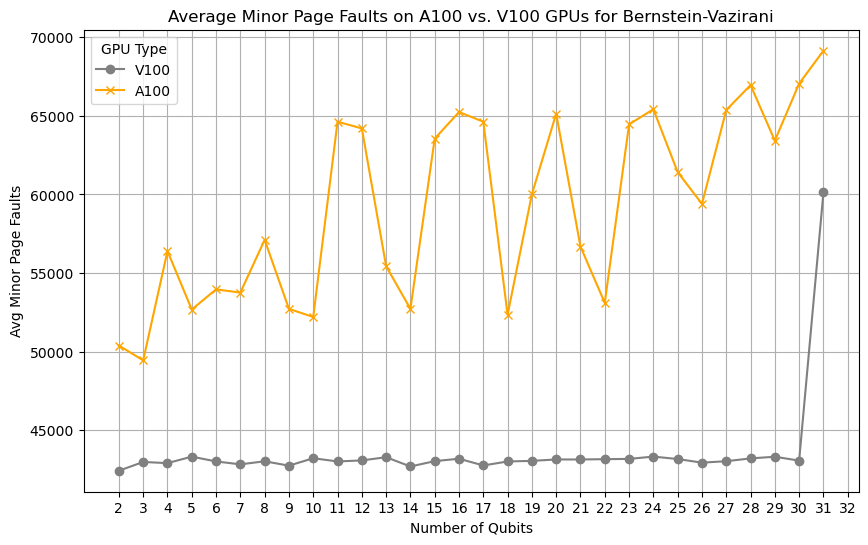

In [41]:
# Function to compute average minor page faults for the last 5 runs per qubit number
def compute_avg_minor_faults(df):
    
    avg_faults_list = []
    
    # Loop over qubit values from 2 to 31 and compute the average of the last 5 runs
    for qubit in range(1, 31):
        df['Qubits'] = pd.to_numeric(df['Qubits'], errors='coerce')
        df['Minor Page Faults'] = pd.to_numeric(df['Minor Page Faults'], errors='coerce')
        df_filtered = df[df['Qubits'] == qubit]
        avg_faults_list.append(df_filtered['Minor Page Faults'].iloc[-5:].mean())
    
    return avg_faults_list

# Compute the averages for both GPUs
avg_minor_v100 = compute_avg_minor_faults(df_bv_v100)
avg_minor_a100 = compute_avg_minor_faults(df_bv_a100)

# Define qubit range
qubits = np.arange(2, 32)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(qubits, avg_minor_v100, label="V100", marker='o', color='grey')
plt.plot(qubits, avg_minor_a100, label="A100", marker='x', color='orange')

# Labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Avg Minor Page Faults')
plt.title('Average Minor Page Faults on A100 vs. V100 GPUs for Bernstein-Vazirani')
plt.legend(title="GPU Type")

plt.xticks(np.arange(2, 33, 1))  # Ensure that ticks are from 2 to 32

# Show the plot
plt.grid(True)
plt.show()

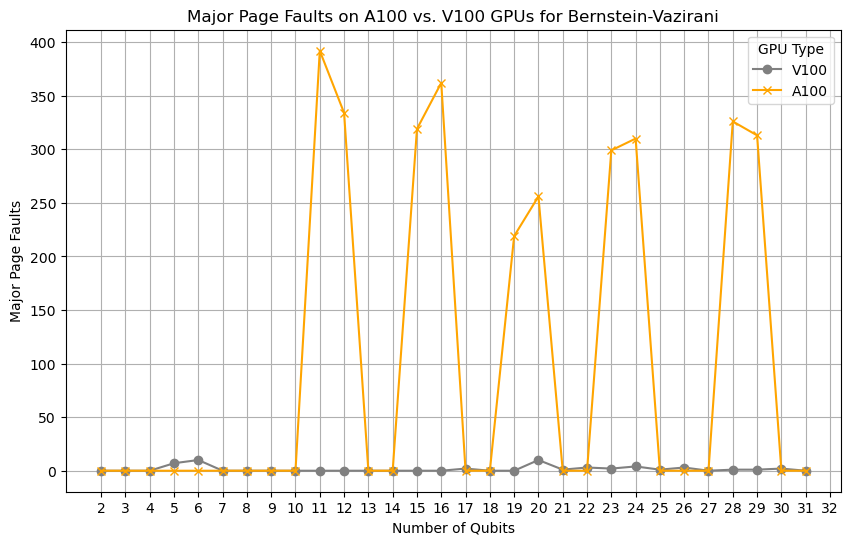

In [42]:
# Function to compute average minor page faults for the last 5 runs per qubit number
def compute_maj_faults(df):
    
    maj_faults_list = []
    
    # Loop over qubit values from 2 to 31 and compute the average of the last 5 runs
    for qubit in range(1, 31):
        df['Qubits'] = pd.to_numeric(df['Qubits'], errors='coerce')
        df['Major Page Faults'] = pd.to_numeric(df['Major Page Faults'], errors='coerce')
        df_filtered = df[df['Qubits'] == qubit]
        maj_faults_list.append(df_filtered['Major Page Faults'].iloc[0])
    
    return maj_faults_list

# Compute the averages for both GPUs
maj_faults_v100 = compute_maj_faults(df_bv_v100)
maj_faults_a100 = compute_maj_faults(df_bv_a100)

# Define qubit range
qubits = np.arange(2, 32)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(qubits, maj_faults_v100, label="V100", marker='o', color='grey')
plt.plot(qubits, maj_faults_a100, label="A100", marker='x', color='orange')

# Labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Major Page Faults')
plt.title('Major Page Faults on A100 vs. V100 GPUs for Bernstein-Vazirani')
plt.legend(title="GPU Type")

plt.xticks(np.arange(2, 33, 1))  # Ensure that ticks are from 2 to 32

# Show the plot
plt.grid(True)
plt.show()


In [48]:
# Define the function first
def process_data(folder_path):
    all_data = []  # Initialize all_data inside the function to avoid overwriting
    # Loop over all files in the directory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
    
        # Check if the current item is a file (not a directory)
        if os.path.isfile(file_path):
            # print(f"Processing file: {filename}")  # Debugging print statement
            
            try:
                with open(file_path, 'r') as f:
                    content = f.read()
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
                continue
    
            # Regular expressions for matching the relevant fields
            user_time = r"User time \(seconds\):\s*([0-9.]+)"
            cpu_percent = r"Percent of CPU this job got:\s*([0-9]+)"
            major_faults = r"Major \(requiring I/O\) page faults:\s*(\d+)"
            minor_faults = r"Minor \(reclaiming a frame\) page faults:\s*(\d+)"
            qubits = r'Command being timed: "python3 qft.py (\d+)"'
    
            # Find the number of qubits in the file (assuming there's only one qubit number per file)
            qubit_match = re.search(qubits, content)
            qubit_number = qubit_match.group(1) if qubit_match else None
            # print(f"Qubits in {filename}: {qubit_number}")  # Debugging print statement
            
            # Find all matches for each pattern
            user_times = re.findall(user_time, content)
            cpu_percents = re.findall(cpu_percent, content)
            major_faults = re.findall(major_faults, content)
            minor_faults = re.findall(minor_faults, content)
    
            # Check if lengths of matches are consistent
            if len(user_times) == len(cpu_percents) == len(major_faults) == len(minor_faults):
                # Combine the results into a structured list
                for i in range(len(user_times)):
                    all_data.append({
                        'Filename': filename,
                        'Qubits': qubit_number,
                        'User Time (s)': user_times[i],
                        'CPU Percent': cpu_percents[i],
                        'Major Page Faults': major_faults[i],
                        'Minor Page Faults': minor_faults[i]
                    })
            else:
                print(f"Mismatch in data lengths for file {filename}. Skipping this file.")
                continue
            
        else:
            print(f"Skipping non-file: {filename}")  # Debugging print statement
    
    # Convert the aggregated data into a DataFrame for easier analysis
    df = pd.DataFrame(all_data)
    
    # Display the DataFrame
    print(df)
    return df

# Define the paths to your two folders
qft_a100_path = '/scratch/network/er4138/iw/qft_a100'
df_qft_a100 = process_data(qft_a100_path)
df_qft_a100.to_csv('/scratch/network/er4138/iw/df_qft_a100.csv', index=False)

qft_v100_path = '/scratch/network/er4138/iw/qft_v100'
df_qft_v100 = process_data(qft_v100_path)
df_qft_v100.to_csv('/scratch/network/er4138/iw/bf_qft_v100.csv', index=False)

Skipping non-file: .ipynb_checkpoints
              Filename Qubits User Time (s) CPU Percent Major Page Faults  \
0    slurm-2360089.out     19          0.78          69                 0   
1    slurm-2360089.out     19          0.77          73                 0   
2    slurm-2360089.out     19          0.78          71                 0   
3    slurm-2360089.out     19          0.79          70                 0   
4    slurm-2360089.out     19          0.79          73                 0   
..                 ...    ...           ...         ...               ...   
295  slurm-2360117.out     30          9.50          97                 0   
296  slurm-2360117.out     30          9.49          96                 0   
297  slurm-2360117.out     30          9.53          97                 0   
298  slurm-2360117.out     30          9.45          97                 0   
299  slurm-2360117.out     30          9.45          97                 0   

    Minor Page Faults  
0            

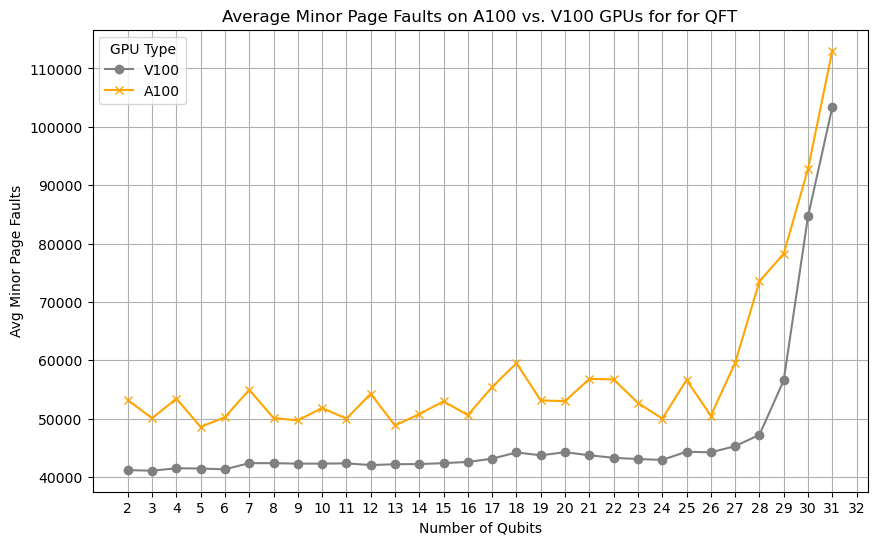

In [50]:
# Function to compute average minor page faults for the last 5 runs per qubit number
def compute_avg_minor_faults(df):
    
    avg_faults_list = []
    
    # Loop over qubit values from 2 to 31 and compute the average of the last 5 runs
    for qubit in range(2, 32):
        df['Qubits'] = pd.to_numeric(df['Qubits'], errors='coerce')
        df['Minor Page Faults'] = pd.to_numeric(df['Minor Page Faults'], errors='coerce')
        df_filtered = df[df['Qubits'] == qubit]
        avg_faults_list.append(df_filtered['Minor Page Faults'].iloc[-5:].mean())
    
    return avg_faults_list

# Compute the averages for both GPUs
avg_minor_v100 = compute_avg_minor_faults(df_qft_v100)
avg_minor_a100 = compute_avg_minor_faults(df_qft_a100)

# Define qubit range
qubits = np.arange(2, 32)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(qubits, avg_minor_v100, label="V100", marker='o', color='grey')
plt.plot(qubits, avg_minor_a100, label="A100", marker='x', color='orange')

# Labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Avg Minor Page Faults')
plt.title('Average Minor Page Faults on A100 vs. V100 GPUs for for QFT')
plt.legend(title="GPU Type")

plt.xticks(np.arange(2, 33, 1))  # Ensure that ticks are from 2 to 32

# Show the plot
plt.grid(True)
plt.show()

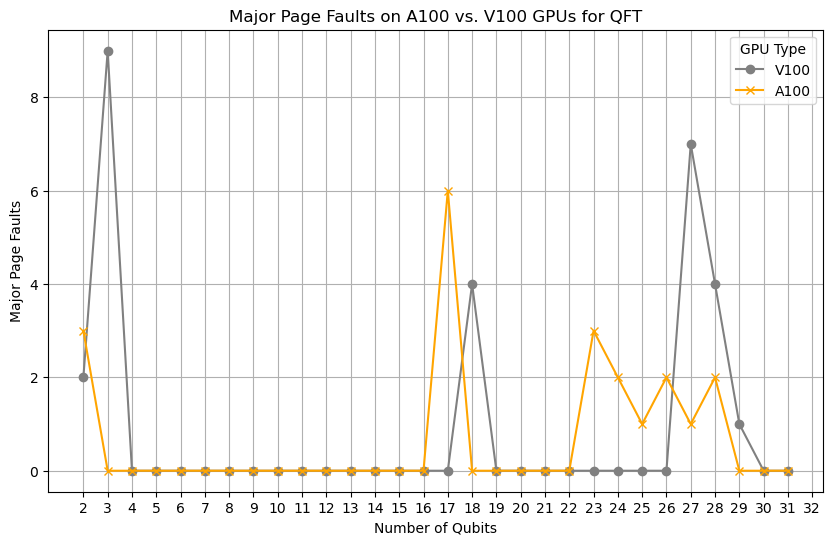

In [51]:
# Function to compute average minor page faults for the last 5 runs per qubit number
def compute_maj_faults(df):
    
    maj_faults_list = []
    
    # Loop over qubit values from 2 to 31 and compute the average of the last 5 runs
    for qubit in range(2, 32):
        df['Qubits'] = pd.to_numeric(df['Qubits'], errors='coerce')
        df['Major Page Faults'] = pd.to_numeric(df['Major Page Faults'], errors='coerce')
        df_filtered = df[df['Qubits'] == qubit]
        maj_faults_list.append(df_filtered['Major Page Faults'].iloc[0])
    
    return maj_faults_list

# Compute the averages for both GPUs
maj_faults_v100 = compute_maj_faults(df_qft_v100)
maj_faults_a100 = compute_maj_faults(df_qft_a100)

# Define qubit range
qubits = np.arange(2, 32)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(qubits, maj_faults_v100, label="V100", marker='o', color='grey')
plt.plot(qubits, maj_faults_a100, label="A100", marker='x', color='orange')

# Labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Major Page Faults')
plt.title('Major Page Faults on A100 vs. V100 GPUs for QFT')
plt.legend(title="GPU Type")

plt.xticks(np.arange(2, 33, 1))  # Ensure that ticks are from 2 to 32

# Show the plot
plt.grid(True)
plt.show()


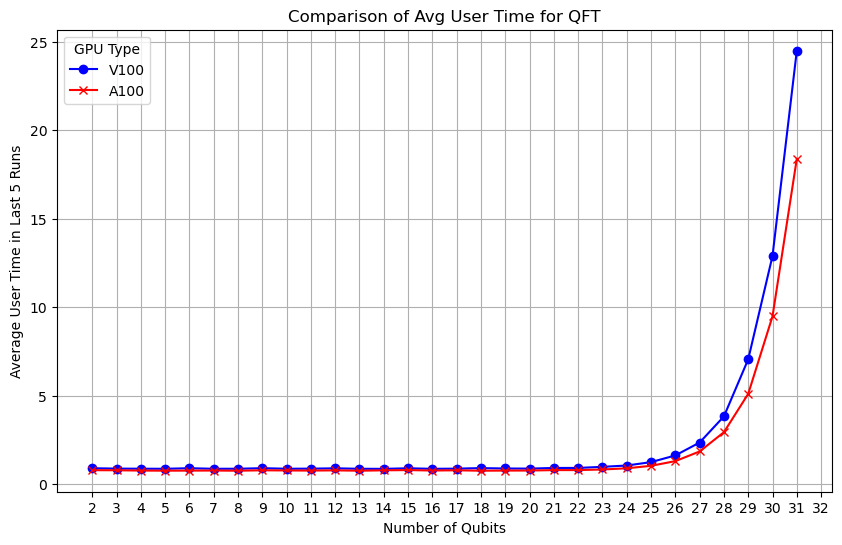

In [52]:
# Function to compute average minor page faults for the last 5 runs per qubit number
def compute_avg_time(df):
    
    avg_user_time = []
    
    # Loop over qubit values from 2 to 31 and compute the average of the last 5 runs
    for qubit in range(2, 32):
        df['Qubits'] = pd.to_numeric(df['Qubits'], errors='coerce')
        df['User Time (s)'] = pd.to_numeric(df['User Time (s)'], errors='coerce')
        df_filtered = df[df['Qubits'] == qubit]
        avg_user_time.append(df_filtered['User Time (s)'].iloc[-5:].mean())
    
    return avg_user_time

# Compute the averages for both GPUs
avg_time_qft_v100 = compute_avg_time(df_qft_v100)
avg_time_qft_a100 = compute_avg_time(df_qft_a100)

# Define qubit range
qubits = np.arange(2, 32)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(qubits, avg_time_qft_v100, label="V100", marker='o', color='blue')
plt.plot(qubits, avg_time_qft_a100, label="A100", marker='x', color='red')

# Labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Average User Time in Last 5 Runs')
plt.title('Comparison of Avg User Time for QFT')
plt.legend(title="GPU Type")

plt.xticks(np.arange(2, 33, 1))  # Ensure that ticks are from 2 to 32

# Show the plot
plt.grid(True)
plt.show()
